In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
import pandas as pd


resol = 300
pi = np.pi
version_table()

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif"
#})

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> RG Scheme </h1>

In [2]:
def update_state(c,b,gamma,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k, 0>
    b (float): Atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * np.sqrt(gamma / (2*L)) * np.exp(-1j * (omega_tab - omega_A) * t)
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))

    b_new = c @ g_matrix
    c_new = b * np.conjugate(g_matrix)

    return -1j* dt * c_new, -1j * dt * b_new

def RG_scheme(c_init, b_init, gamma, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k, 0>
    b_init (float): initial atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(c_init)//2
    c_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)
    b_array = np.zeros(nb_pts_time, dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, gamma, omega_tab, omega_A, L, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, gamma, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, gamma, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, gamma, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 
    

<h1> Function that treats the whole evolution </h1>

In [6]:
def get_data_decay_fast(L, T, dt, omega_A, omega_max, gamma, print_nb_modes = False, progress_bar=True):
    """
    Generate data for the RG scheme with a mirror.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k, 0>.
    b_array (np array): Coefficients in front of the state |0, 1>.
    omega_tab (np array): Array of frequencies.
    """
    
    #quantization of the modes
    omega_tab_individual = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_individual)
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    print("Preparing the initial state...")
    c_init = np.zeros(2*n_modes, dtype=complex)
    b_init = 1

    ##evolve the state
    print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, gamma, omega_tab_individual, omega_A, L, T, dt, progress_bar=progress_bar)


    return c_array, b_array, k_tab_individual

###For comparison with ED

def get_data_decay_ed(L, T, dt, omega_A, omega_max, gamma, print_nb_modes = False):
    #quantization of the modes
    omega_tab_individual = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_individual)
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = 2*n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    for i in range(n_modes):

        #diagonal elements
        H_matrix[i, i] = omega_tab_individual[i]
        H_matrix[i+n_modes, i+n_modes] = omega_tab_individual[i]

        #off diagonal elements
        H_matrix[2*n_modes,i] = 1j*np.sqrt(gamma/(2*L))
        H_matrix[2*n_modes, i+n_modes] = 1j*np.sqrt(gamma/(2*L))

        H_matrix[i,2*n_modes] = -1j*np.sqrt(gamma/(2*L))
        H_matrix[i+n_modes, 2*n_modes] = -1j*np.sqrt(gamma/(2*L))

    H_matrix[2*n_modes, 2*n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None

    print("Initializing the state ...")
    ##Initial state

    init_state = qt.basis(dim_subspace, n_modes)
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states
    
    return times, state_list

<h1> First test </h1>

Generate an example

In [56]:
L = 30*pi
T = 0.3*L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
omega_A = 10
omega_0 = 10

#gamma = g_0**2 * omega_A
gamma = 1

omega_max = 50

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4

#check some parameters
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)
print("Value of gamma", gamma, "and sigma_momentum = ", sigma_momentum)

50% Reflectivity for omega_0_m =  9  and omega_0_p =  11
Value of gamma 1 and sigma_momentum =  0.16976527263135505


In [57]:
c_array, b_array, k_tab = get_data_decay_fast(L, T, dt, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes=True)

#ED comparision
ed = False

if ed:
    dt_ed = 0.01
    print("Exact diagonalization...")
    times_ed, state_list_ed = get_data_decay_ed(L, T, dt_ed, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes = True)

Number of modes:  751
Preparing the initial state...
Evolving the state...


  0%|          | 0/1412 [00:00<?, ?it/s]

<h1> Occupation numbers </h1>

In [58]:
time_array = np.linspace(0, T, int(T / dt))
# Prepare the k_tab for occupation numbers
n_modes = len(k_tab)
nb_pts_time = int(T / dt)
p_atom =  np.zeros(nb_pts_time)

for i in tqdm(range(nb_pts_time)):
    p_atom[i] = np.abs(b_array[i])**2  

wave_fct_emitted = np.abs(c_array[-1])**2
index_max_freq = np.argmax(wave_fct_emitted[:n_modes])
print("omega_A_pys = ", k_tab[index_max_freq])

mean_freq = np.sum(k_tab * wave_fct_emitted[:n_modes]) / np.sum(wave_fct_emitted[:n_modes])
print("mean freq emitted = ", mean_freq)


if ed:
    #comparing with ed
    nb_pts_time_ed = len(times_ed)
    p_atom_ed =  np.zeros(nb_pts_time_ed)

    for i in tqdm(range(nb_pts_time_ed)):
        current_state = state_list_ed[i].full().reshape(2*n_modes+1)
        p_atom_ed[i] = np.abs(current_state[2*n_modes]**2)    
    

  0%|          | 0/1413 [00:00<?, ?it/s]

omega_A_pys =  9.8
mean freq emitted =  9.999999849171655


<h1> Atomic decay and emitted photon</h1>

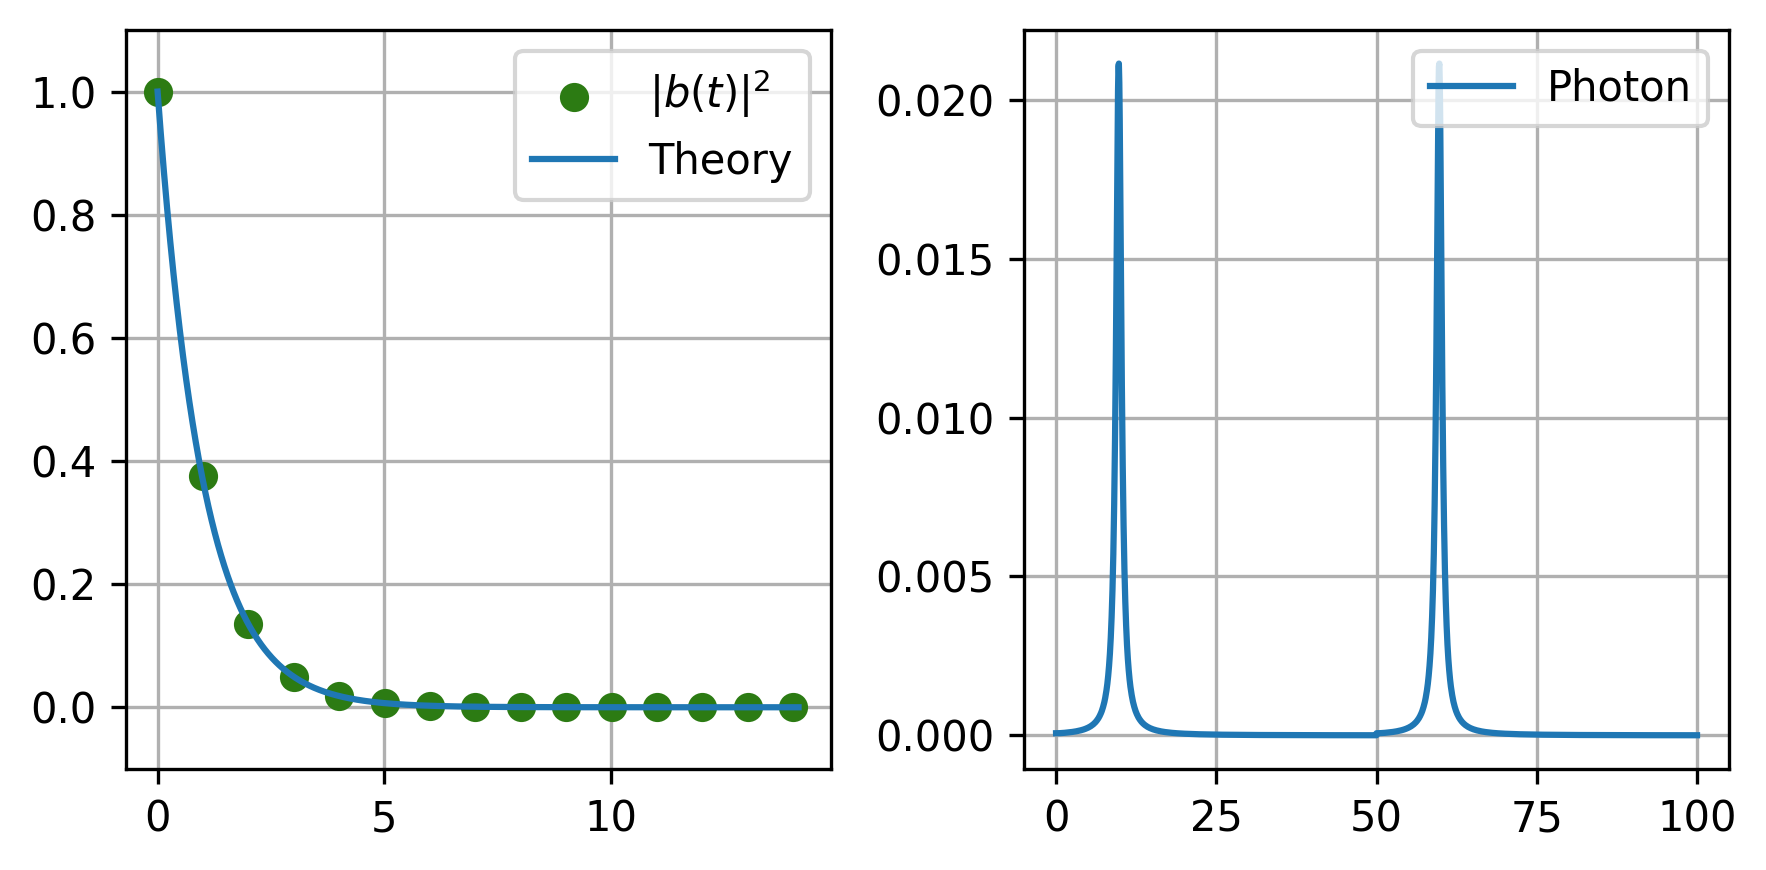

In [59]:
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=resol)

step_to_show = 100

ax[0].scatter(time_array[::step_to_show], p_atom[::step_to_show], label=r'$|b(t)|^2$', color='#2c7b13')   
if ed:
    ax[0].plot(times_ed, p_atom_ed,color='#174708', alpha=0.6, linestyle='--') 
ax[0].plot(time_array, np.exp(-gamma*time_array), label='Theory')
ax[0].set_ylim(-0.1,1.1)

ax[1].plot(np.concatenate((k_tab, omega_max + k_tab)), wave_fct_emitted, label='Photon' )

for i in range(2):
    ax[i].grid()
    ax[i].set_axisbelow(True)  
    ax[i].legend(prop={'size': 10}, loc="upper right")

plt.tight_layout()
#plt.savefig("./fig/one_photon_ex_b.pdf")
plt.show()

<h1> Is the renormalization visible in the emitted spectrum ? </h1>

In [7]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
omega_A = 5
omega_0 = 5
#gamma = g_0**2 * omega_A
gamma = 1

nb_freq = 50
p_1_tab = np.zeros(nb_freq)
omega_max_tab = np.linspace(2*omega_A, 30*omega_A, nb_freq)

omega_mean_tab = np.zeros(nb_freq)
omega_argmax_tab = np.zeros(nb_freq)


for i in tqdm(range(nb_freq)):
    omega_max = omega_max_tab[i]
    #Running a decay experiment
    c_array, b_array, k_tab = get_data_decay_fast(L, T, dt, omega_A, omega_max, gamma, print_nb_modes=False, progress_bar=False)
    #get the renormalized frequency
    n_modes = len(k_tab)

    c_final_A = c_array[-1,:n_modes]

    mean_freq = np.sum(k_tab * np.abs(c_final_A)**2) / np.sum(np.abs(c_final_A)**2)
    omega_mean_tab[i] = mean_freq

    omega_argmax_tab[i] = k_tab[np.argmax(c_final_A)]
    

  0%|          | 0/50 [00:00<?, ?it/s]

Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the st

Check consistency

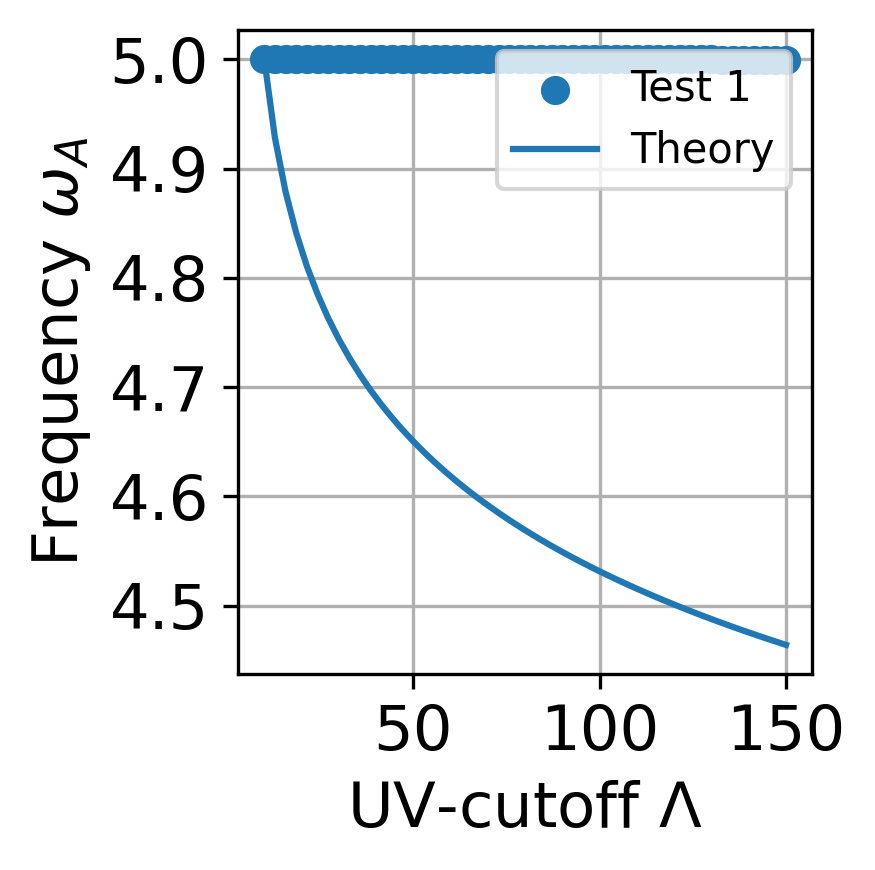

In [9]:
omega_A_phys_theory = omega_A - gamma/(2*pi) * np.log((omega_max_tab - omega_A)/omega_A)

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

step_to_show = 100
ax.scatter(omega_max_tab, omega_mean_tab, label='Test 1')   
#ax.scatter(omega_max_tab, omega_argmax_tab, label='Test 2')   
ax.plot(omega_max_tab, omega_A_phys_theory, label='Theory')



ax.set_xlabel(r'UV-cutoff $\Lambda$')
ax.set_ylabel(r'Frequency $\omega_A$')

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax.grid()
ax.set_axisbelow(True)  
ax.legend(prop={'size': 10}, loc="upper right")

plt.tight_layout()
#plt.savefig("./fig/one_photon_ex_b.pdf")
plt.show()